In [1]:
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks, peak_prominences, peak_widths
import time
import multiprocessing as mp
import pandas as pd
import copy
import sys
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize, BoundaryNorm, LogNorm
from matplotlib.ticker import MaxNLocator
from scipy.special import powm1

solver=["BDF","RK23","LSODA","Radau"]

In [2]:
def ODE(tm,y,k0,L0,n0,K0,LD):
    
    k=k0
    L=L0
    n=n0
    K=K0
    kd=[2.4,2.5,0.135,0.085,0.05,0.05,6,2,0.27,0.27,0.27,0.27,6.2,0.24,0.24]
    
    #Tiempo y periodos LD
    m=Decimal(tm)%Decimal(24)
    if float(m)>=LD:
        l = 0
    else:
        l = L

    #Ecuaciones 
    v0 = k[0]
    v1 = k[1]*y[5]
    v2 = k[2]*y[6]
    v3 = k[3]/(1 + K[0]*y[5])
    v4 = k[4]*y[11]
    v5 = k[5]*y[0]
    v6 = k[6]*(y[0] + y[10] + K[1] -  np.sqrt(pow(y[0] + y[10] + K[1],2) - 
                                              4*y[0]*y[10]))/2
    v7 = k[7]*y[1]
    v8 = k[8]*y[2]*y[3]
    v9 = k[9]*y[4]
    v10 = k[10]*y[6]
    v11 = float(k[11]*y[5]*(pow(y[11],float(n[0])))/(pow(y[11],float(n[0])) + 
                                              pow(K[2],float(n[0]))))
    v12 = k[12]*y[5]
    v13 = float(k[13]*y[6]*(pow(y[14],float(n[1])))/(pow(y[14],float(n[1])) + 
                                              pow(K[3],float(n[1]))))
    v14 = float(k[14]*(pow(K[5]*y[5],float(n[2])))/(pow(K[4]*K[5],float(n[2])) + 
                                              pow(K[5]*y[5],float(n[2])) + 
                                              pow(K[4]*y[6],float(n[2]))))
    v15 = float(k[15]*(pow(K[4]*y[6],float(n[2])))/(pow(K[4]*K[5],float(n[2])) + 
                                               pow(K[5]*y[5],float(n[2])) + 
                                               pow(K[4]*y[6],float(n[2]))))
    v16 = k[16]*y[7]
    v17 = k[17]*y[8]
    v18 = k[18]*y[9]
    v19 = k[19]*y[10]
    v20 = float(k[20])*pow(float(y[6]),float(n[3]))/(pow(float(K[6]),float(n[3])) + 
                                                            pow(float(y[6]),float(n[3])))
    v21 = k[21]*y[12]
    v22 = k[22]*y[13]
    v23 = l*y[5]
    v24 = kd[0]*y[0]
    v25 = kd[1]*y[1]
    v26 = kd[2]*y[2]
    v27 = kd[3]*y[3]
    v28 = kd[4]*y[4] 
    v29 = kd[5]*y[5]
    v30 = kd[6]*y[6] 
    v31 = kd[7]*y[7] 
    v32 = kd[8]*y[8]
    v33 = kd[9]*y[9] 
    v34 = kd[10]*y[10] 
    v35 = kd[11]*y[11] 
    v36 = kd[12]*y[12] 
    v37 = kd[13]*y[13] 
    v38 = kd[14]*y[14]
    
    
    dwc1 = v0 + v1 + v2 - v24
    dwc2 = v3 + v4 - v25
    dWC1 = v5 + v6 - v8 - v26
    dWC2 = v7 - v27 - v8
    dWCCc = v8 - v28 -  v9
    dWCCn = v9 + v10 - v29 - v23 - v12 - v11
    dlaWCC = v23 + v12 - v30 - v10 - v13
    dfrq =  v14 + v15 - v31
    dFRQ =  v16 - v32 - v17
    dFFC = v17 - v33 - v18
    dFFCp = v18 - v34 - v19
    dFFCn = v19 - v35
    dvvd = v20 - v36
    dVVDc = v21 - v37 -  v22
    dVVDn = v22 - v38
    return [dwc1, dwc2, dWC1, dWC2, dWCCc, dWCCn, dlaWCC, dfrq, dFRQ, dFFC, dFFCp, dFFCn, dvvd, dVVDc, dVVDn]

# Parameter's set
## Tseng
k0 = [1.19\*omega,1.2,90,1.6\*omega,0.03,0.226,0.8,1,0.472\/omega,0.3,0.001,0.6,0.001,20,7.3,320\*omega,0.19,
      0.15,0.1,0.1,800\*omega,0.68,0.3]
      
L0 = 0.2

n0 = [4,4,4,4]

Km0 = [0.03\/omega,1\*omega,0.475\*omega,5\*omega,0.1\*omega,0.18\*omega,0.02\*omega]

## Tseng modified

k0 = [1.19, 1.2, 90, 1.6, 0.03, 0.226, 2.4, 2, 0.472, 0.3, 0.001, 50, 
      0.001, 20, 7.3, 320, 5.4, 0.15, 2, 0.05, 800, 0.68, 0.3]
      
n0 = [2,3,3,4]

L0 = 0.3

Km0 = [0.03, 0.3, 0.05, 5, 2, 0.18, 0.02]

## Oscillations in LD and DD of an old evolutionary simulation
k0 = [9.18236260e-01, 1.31272389e+00, 1.05612953e+02, 1.51368699e+00, 3.34960765e-02, 2.23445399e-01, 
      2.12373377e+00, 2e+00, 4.72000000e-01, 3.00000000e-01, 1.00000000e-03, 8.22563158e+00, 1.0e-03, 
      1.08551588e+01, 3.49620056e+00, 3.43058956e+02, 5.40000000e+00, 1.50e-01, 2e+00, 5e-02, 8.58342556e+02, 
      6.80000000e-01, 3.00000000e-01]
      
L0 = 0.2

n0 = [4, 4, 4, 4]

Km0 = [0.0271708,  0.29283663, 0.04372374, 4.63129806, 3.89618486, 0.1634689, 0.01747003]

## Oscillations in LD and DD of a new evolutionary simulation
k0 = [1.60361527e+00, 1.34698905e+00, 9.44635006e+01, 3.70162498e+00, 2.18129314e-02, 1.23083233e-01,
      3.37528481e+00, 1.97998004e+00, 8.91902116e-01, 3.99460912e-01, 5.40020047e-04, 8.83366542e+00,
      1.31907102e-03, 1.13631597e+01, 2.08602327e+00, 2.15434751e+02, 4.30201083e+00, 1.16989157e-01,
      1.62312295e+00, 3.05100443e-02, 6.83151607e+02, 6.32459003e-01, 1.80697224e-01]
      
L0 = 0.25

n0 = [2.91692706, 7.21930474, 4.00416676, 3.15341046]

Km0 = [4.22350262e-02, 2.43900739e-01, 4.50013924e-02, 8.08635690e+00, 5.77864438e+00, 
       9.28467919e-02, 7.86925307e-03]
       

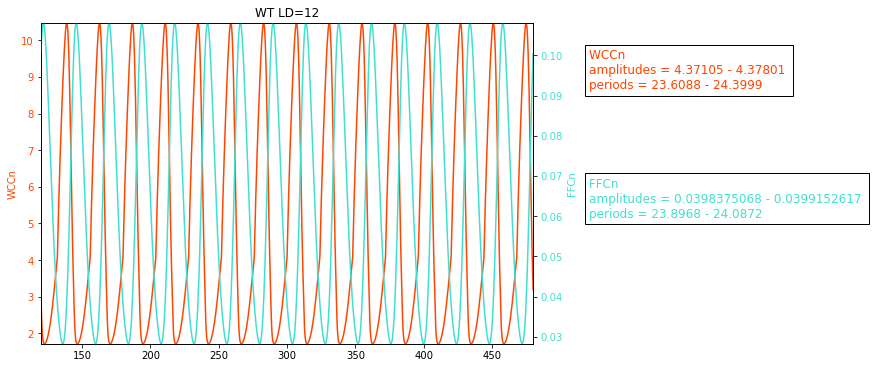

In [282]:
omega=13
x0 = np.zeros(15)
ip=1
if ip==0:
    k0 = [1.19*omega,1.2,90,1.6*omega,0.03,0.226,0.8,1,0.472/omega,
          0.3,0.001,0.6,0.001,20,7.3,320*omega,0.19, 0.15,0.1,0.1,800*omega,0.68,0.3]
    L0 = 0.2
    n0 = [4,4,4,4]
    Km0 = [0.03/omega,1*omega,0.475*omega,5*omega,0.1*omega,0.18*omega,0.02*omega]
elif ip==1:
    k0 = [1.19*omega, 1.2, 90, 1.6*omega, 0.03, 0.226, 2.4, 2, 0.472/omega, 0.3, 0.001, 50, 
          0.001, 20, 7.3, 320, 5.4, 0.15, 2, 0.05, 800*omega, 0.68, 0.3]
    n0 = [2,3,3,4]
    L0 = 0.3
    Km0 = [0.03/omega, 0.3*omega, 0.05*omega, 5*omega, 2*omega, 0.18*omega, 0.02*omega]
elif ip==2:
    k0 = [9.18236260e-01, 1.31272389e+00, 1.05612953e+02, 1.51368699e+00, 
          3.34960765e-02, 2.23445399e-01, 2.12373377e+00, 2e+00, 4.72000000e-01, 
          3.00000000e-01, 1.00000000e-03, 8.22563158e+00, 1.0e-03, 1.08551588e+01, 
          3.49620056e+00, 3.43058956e+02, 5.40000000e+00, 1.50e-01, 2e+00, 5e-02, 
          8.58342556e+02, 6.80000000e-01, 3.00000000e-01]
    L0 = 0.2
    n0 = [4, 4, 4, 4]
    Km0 = [0.0271708, 0.29283663, 0.04372374, 4.63129806, 3.89618486, 0.1634689, 0.01747003]
elif ip==3:
    k0 = [1.60361527e+00, 1.34698905e+00, 9.44635006e+01, 3.70162498e+00, 2.18129314e-02, 
          1.23083233e-01, 3.37528481e+00, 1.97998004e+00, 8.91902116e-01, 3.99460912e-01, 
          5.40020047e-04, 8.83366542e+00, 1.31907102e-03, 1.13631597e+01, 2.08602327e+00, 
          2.15434751e+02, 4.30201083e+00, 1.16989157e-01, 1.62312295e+00, 3.05100443e-02, 
          6.83151607e+02, 6.32459003e-01, 1.80697224e-01]
    L0 = 0.25
    n0 = [2.91692706, 7.21930474, 4.00416676, 3.15341046]
    Km0 = [4.22350262e-02, 2.43900739e-01, 4.50013924e-02, 8.08635690e+00, 5.77864438e+00, 
           9.28467919e-02, 7.86925307e-03] 

LD=12
sol=solve_ivp(ODE,[0,480],x0,args=(k0,L0,n0,Km0,LD),method=solver[2])
fig = plt.figure(figsize=(12,5),layout="constrained")
gs = gridspec.GridSpec(1, 4, figure=fig)
ax1 = fig.add_subplot(gs[:-1])
y1=sol.y[5]
amp1=max(y1[sol.t>192])-min(y1[sol.t>192])
peaks1,_=find_peaks(y1[sol.t>120],height=min(y1[sol.t>192])+amp1/2)
p1=np.diff(sol.t[sol.t>120][peaks1])
amp1=(y1[sol.t>120][peaks1]-min(y1[sol.t>192]))/2
if not peaks1.size>1:
    p1=np.append(p1,0)
    amp1=np.append(amp1,0)

color=["orangered","turquoise"]
ax1.plot(sol.t,y1,color=color[0])
ax1.tick_params(axis='y', labelcolor=color[0])
ax1.set_ylabel('WCCn', color=color[0])
ax1.set_xlim([120,480])
ax1.set_ylim([min(y1[sol.t>120]),max(y1[sol.t>120])])
ax1.set_title("WT LD="+str(LD))

ax2 = ax1.twinx()
y2=sol.y[11]
amp2=max(y2[sol.t>192])-min(y2[sol.t>192])
peaks2,_=find_peaks(y2[sol.t>120],height=min(y2[sol.t>192])+amp2/4)
p2=np.diff(sol.t[sol.t>120][peaks2])
amp2=(y2[sol.t>120][peaks2]-min(y2[sol.t>192]))/2
if not peaks2.size>1:
    p2=np.append(p2,0)
    amp2=np.append(amp2,0)

ax2.plot(sol.t,y2,color=color[1])
ax2.tick_params(axis='y', labelcolor=color[1])
ax2.set_ylabel('FFCn', color=color[1])
ax2.set_ylim([min(y2[sol.t>120]),max(y2[sol.t>120])])

ax3 = fig.add_subplot(gs[-1])
text = ("WCCn \namplitudes = {} - {} ".format(round(amp1.min(),5),round(amp1.max(),5))+
        "\nperiods = {} - {}".format(round(p1.min(),4),round(p1.max(),4)))
ax3.text(-.1,0.8,text,c=color[0], fontsize=12, ha="left", wrap=True, bbox=dict(fc="none"))
text = ("FFCn \namplitudes = {} - {} ".format(round(amp2.min(),10),round(amp2.max(),10))+
        "\nperiods = {} - {}".format(round(p2.min(),4),round(p2.max(),4)))
ax3.text(-.1,0.4,text,c=color[1], fontsize=12, ha="left", wrap=True, bbox=dict(fc="none"))
ax3.set(xlim=(-0.15, 1.15), ylim=(0, 1))
ax3.axis("off")
plt.savefig("Result/WT_LD={}_ip{}.jpg".format(LD,ip))
plt.show()

In [10]:
pd.DataFrame(sol.y[:,-1]).apply(round,args=[2])

,0
0,4.69
1,0.51
2,5.06
3,0.21
4,1.42
5,8.29
6,0.00
7,3.65
8,1.65
9,0.67


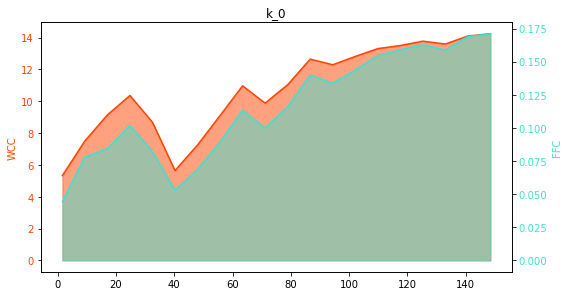

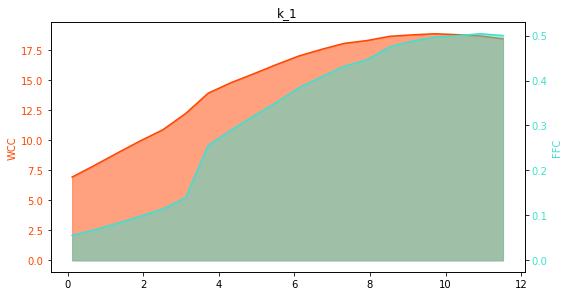

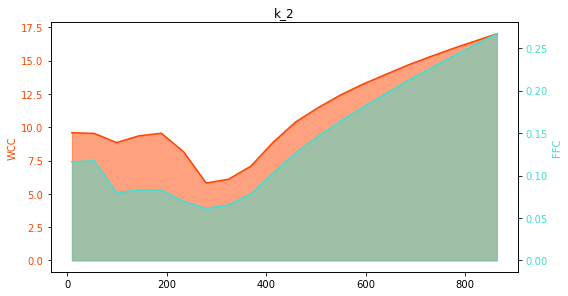

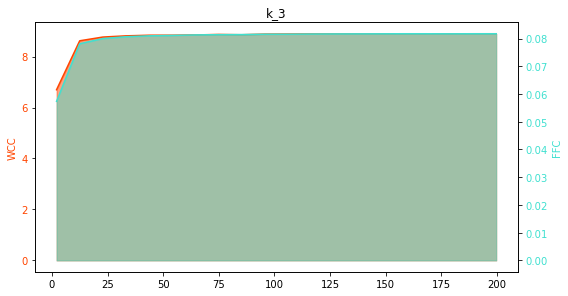

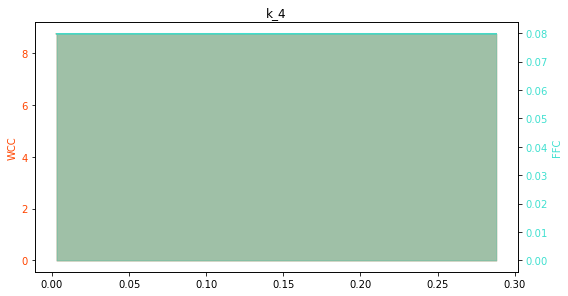

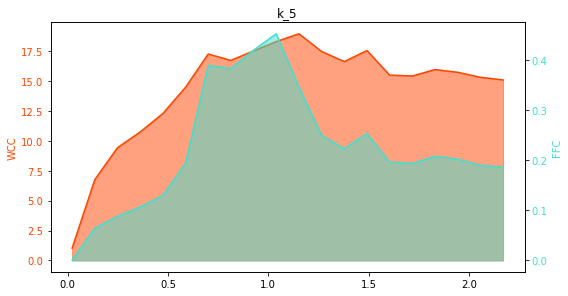

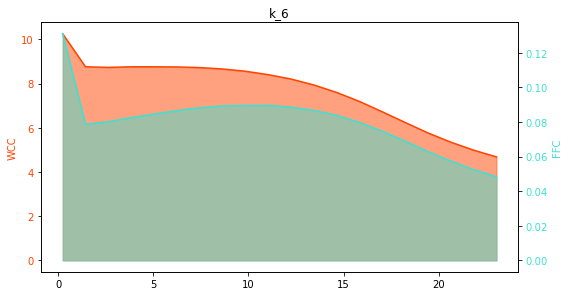

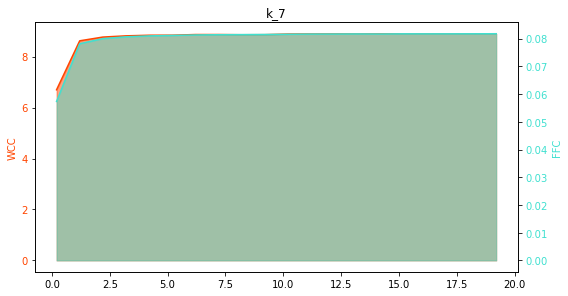

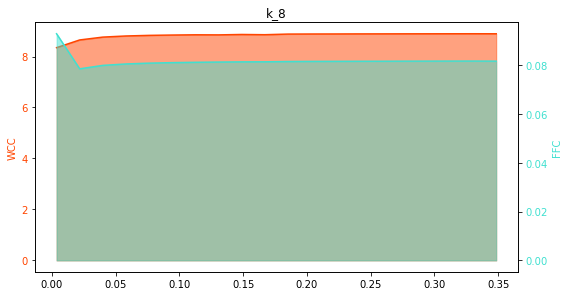

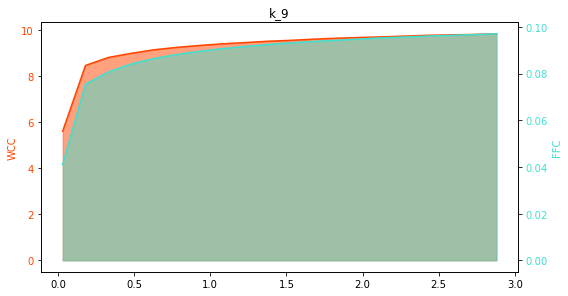

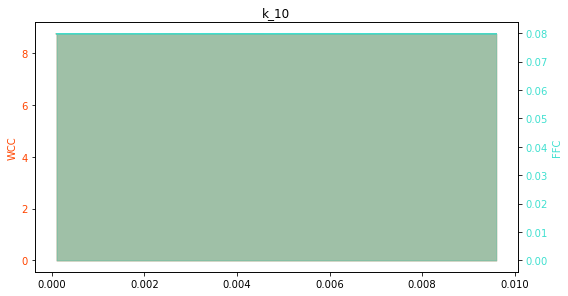

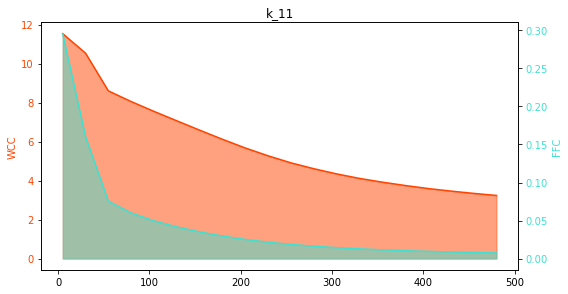

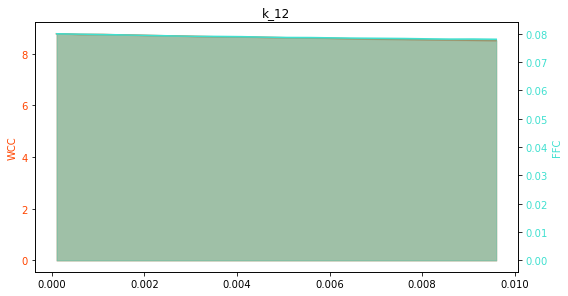

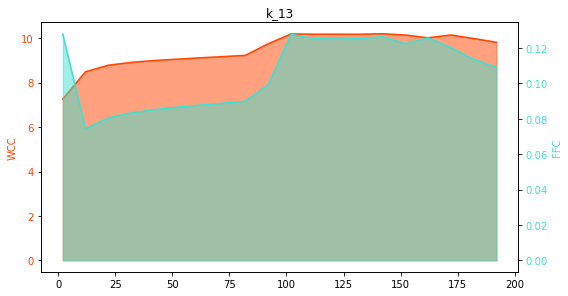

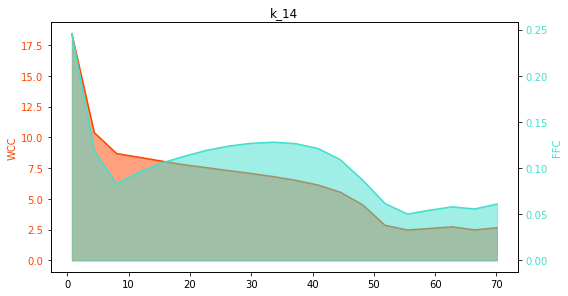

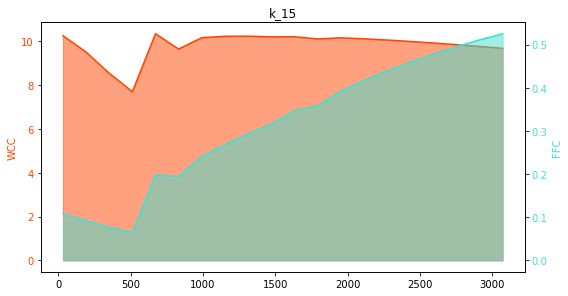

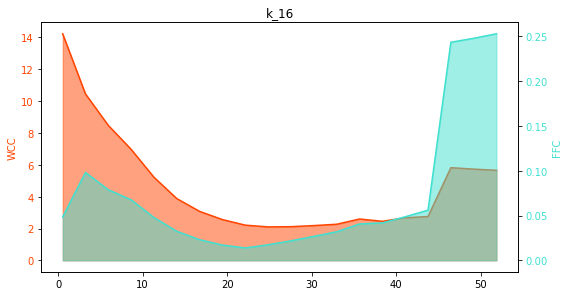

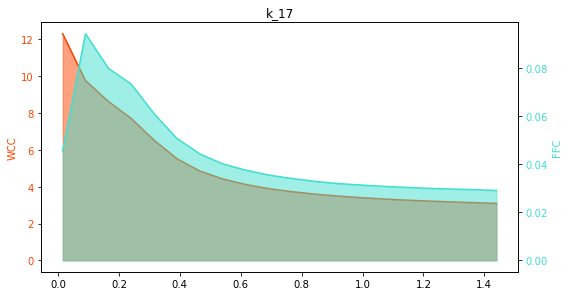

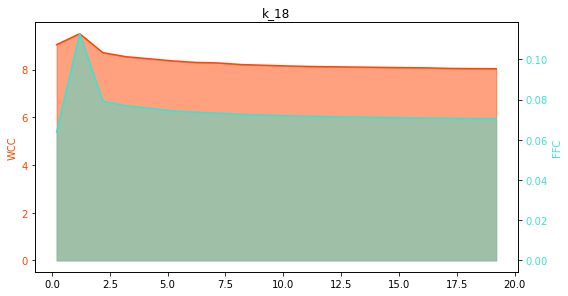

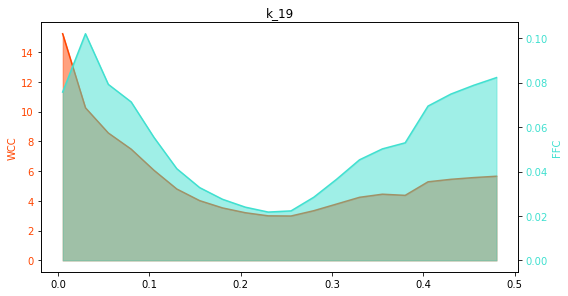

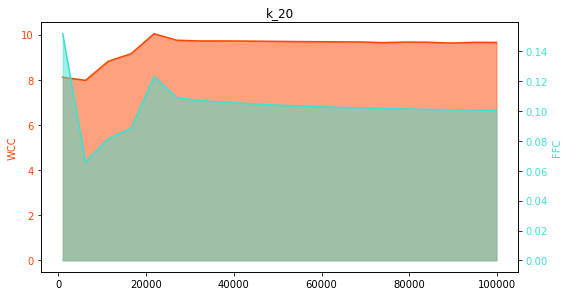

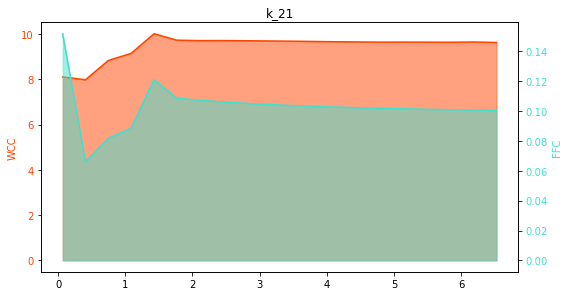

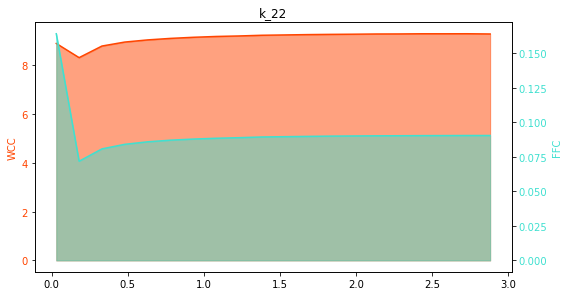

C:\Users\emman\AppData\Local\Temp\ipykernel_31020\3586453168.py:28: RuntimeWarning: invalid value encountered in double_scalars
  v11 = k[11]*y[5]*(pow(y[11],n[0])/(pow(y[11],n[0]) + pow(K[2],n[0])))


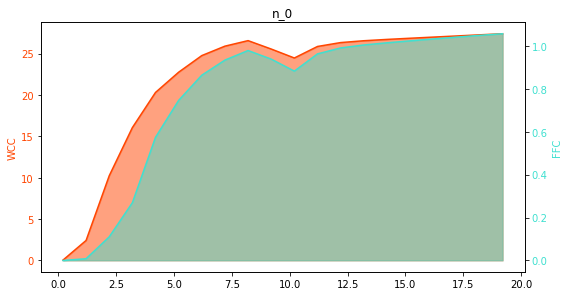

C:\Users\emman\AppData\Local\Temp\ipykernel_31020\3586453168.py:30: RuntimeWarning: invalid value encountered in double_scalars
  v13 = k[13]*y[6]*float(y[14]**n[1])/float(y[14]**n[1] + K[3]**n[1])


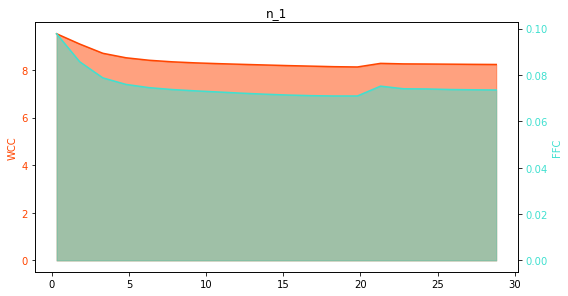

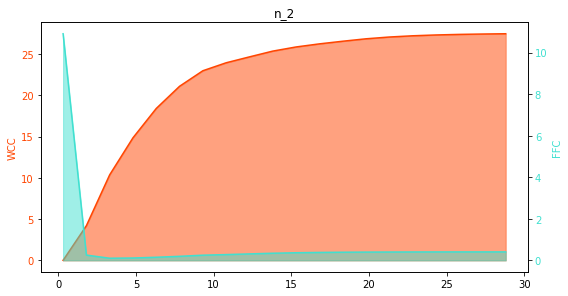

C:\Users\emman\AppData\Local\Temp\ipykernel_31020\3586453168.py:39: RuntimeWarning: invalid value encountered in double_scalars
  v20 = k[20]*float(y[6]**n[3])/(float(K[6]**n[3]) + float(y[6]**n[3]))


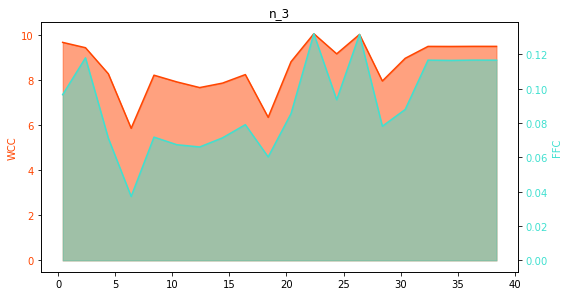

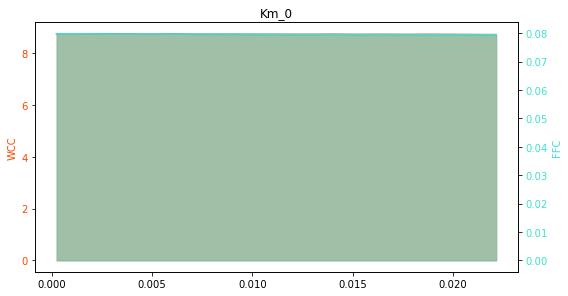

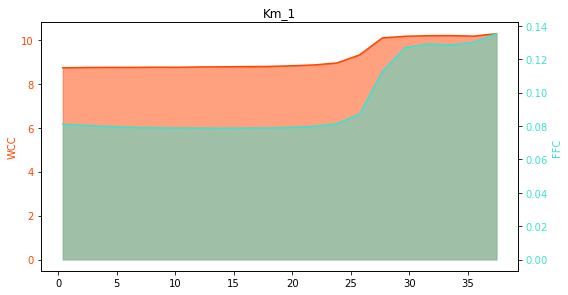

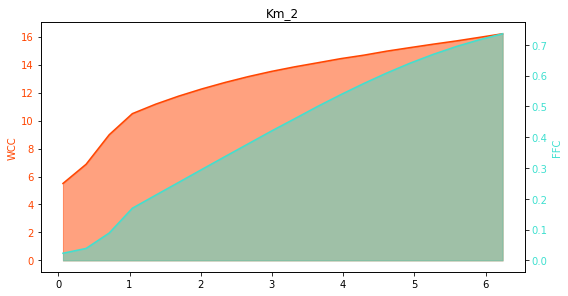

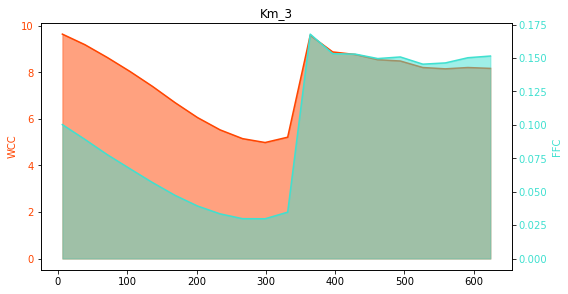

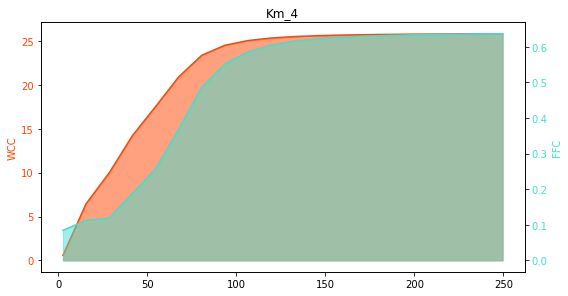

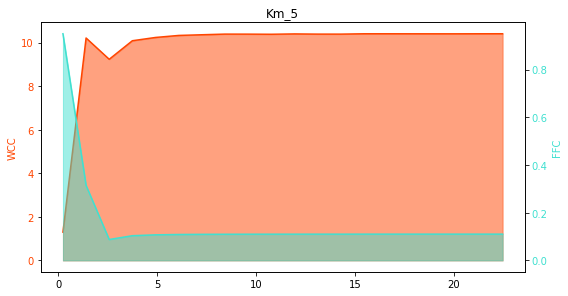

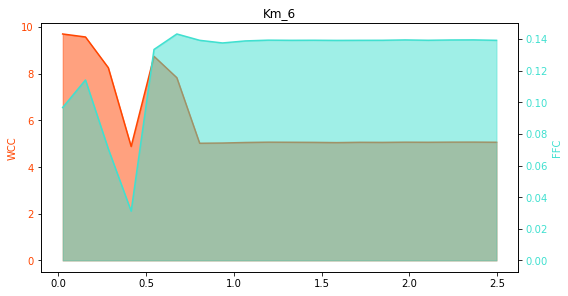

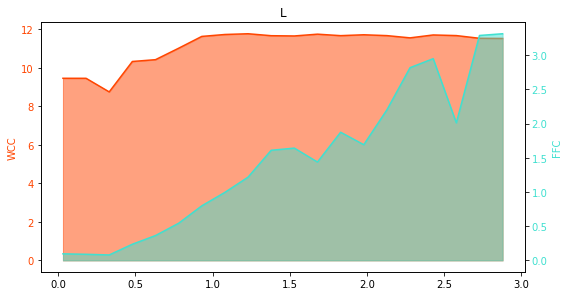

In [491]:
omega=13
x0 = np.zeros(15)
k0 = [1.19*omega, 1.2, 90, 1.6*omega, 0.03, 0.226, 2.4, 2, 0.472/omega, 0.3, 0.001, 50, 
      0.001, 20, 7.3, 320, 5.4, 0.15, 2, 0.05, 800*omega, 0.68, 0.3]
n0 = [2,3,3,4]
L0 = 0.3
Km0 = [0.03/omega, 0.3*omega, 0.05*omega, 5*omega, 2*omega, 0.18*omega, 0.02*omega]
param=[0]*35
param[0:23]=k0
param[23:27]=n0
param[27:34]=Km0
param[34]=L0
LD=12
for j in range(35):
    d1=np.zeros(20)
    d2=np.zeros(20)
    n=copy.copy(param[j])
    for i in range(0,100,5):
        param[j] = (n/10)*(i)
        k1 = param[0:23]
        n1 = param[23:27]
        Km1 = param[27:34]
        L1 = param[34]
        
        try:
            sol = solve_ivp(ODE,[0,480],x0,
                                 args=(k1,L1,n1,Km1,LD),method=solver[0])
        except:
            sol = solve_ivp(ODE,[0,480],x0,
                                 args=(k1,L1,n1,Km1,LD),method=solver[1])
        finally:
            if not sol.success:
                sol = solve_ivp(ODE,[0,480],x0,
                                 args=(k1,L1,n1,Km1,LD),method=solver[2])
        x1=sol.y[5]
        x2=sol.y[11]
        mx1 = max(x1[sol.t>240]);
        mn1 = min(x1[sol.t>240]);
        mx2 = max(x2[sol.t>240]);
        mn2 = min(x2[sol.t>240]);
        d1[int(i/5)] = mx1-mn1;
        d2[int(i/5)] = mx2-mn2;

    param[0:23]=k0
    param[23:27]=n0
    param[27:34]=Km0
    param[34]=L0
    
    #d1=np.log(d1)
    #d2=np.log(d2)
    fig,ax1 = plt.subplots(figsize=(8,4))
    color="orangered"
    ax1.fill_between((np.arange(0,100,5))*(n/10),d1,alpha=0.5,color=color)
    ax1.plot((np.arange(0,100,5))*(n/10),d1,color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylabel('WCC', color=color)
    
    ax2 = ax1.twinx()
    color="turquoise"
    ax2.fill_between((np.arange(0,100,5))*(n/10),d2,alpha=0.5,color=color)
    ax2.plot((np.arange(0,100,5))*(n/10),d2,color=color)
    if (d2==0).any() or (d1==0).any():
        ax2.text(n,max(d2),"*")
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('FFC', color=color)
    fig.tight_layout()
    
    if j<23:
        s = "k_"
        i=j
    elif j<27:
        s = "n_"
        i=j-23
    elif j<34:
        s = "Km_"
        i=j-27
    else:
        s = "L"
        i=""
    plt.title(s+str(i))
    #plt.savefig("Result/{}{}_LD{}.jpg".format(s,i,LD))
    plt.show()

In [ ]:
plt.plot(sol.y.T)

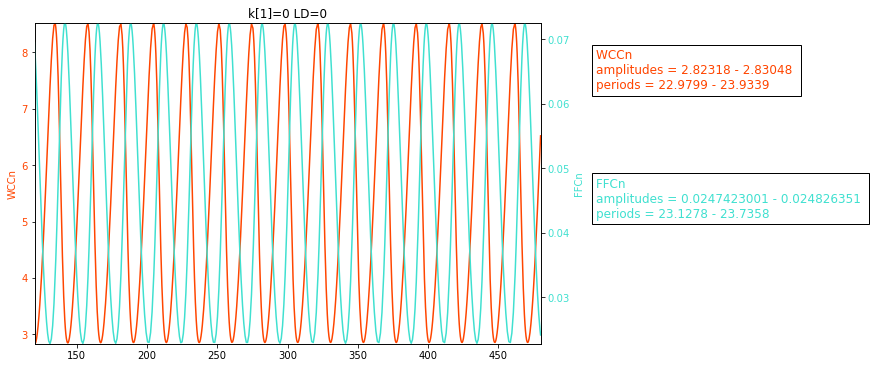

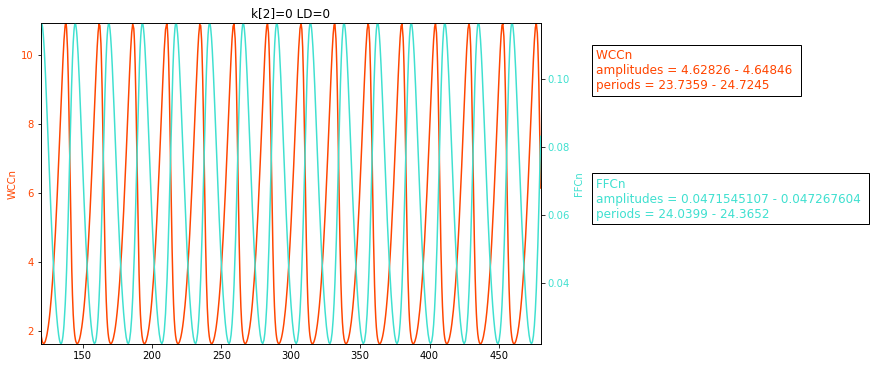

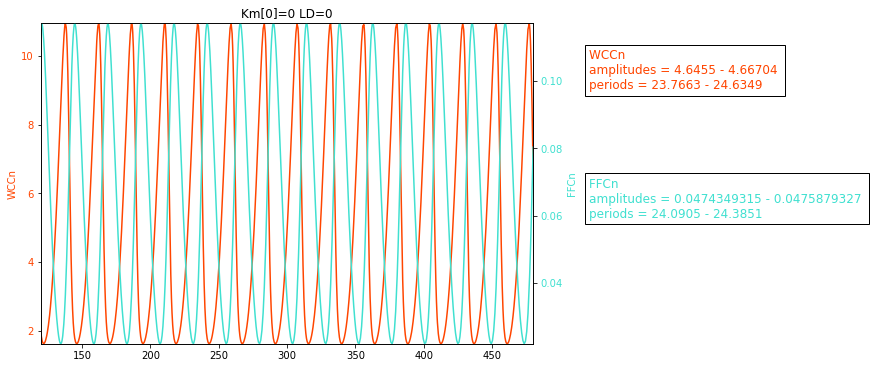

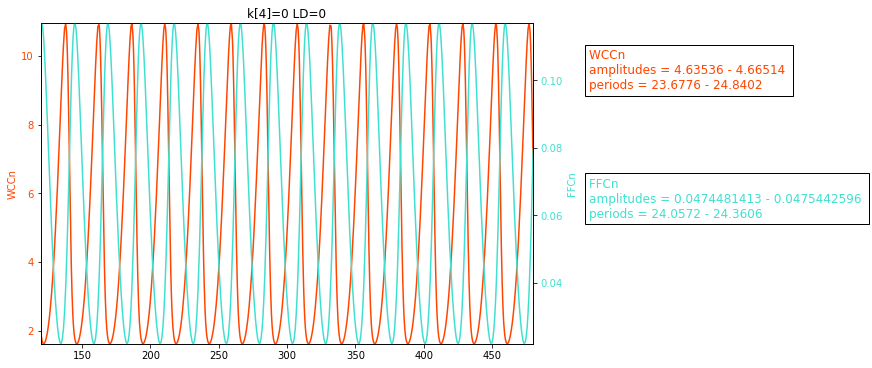

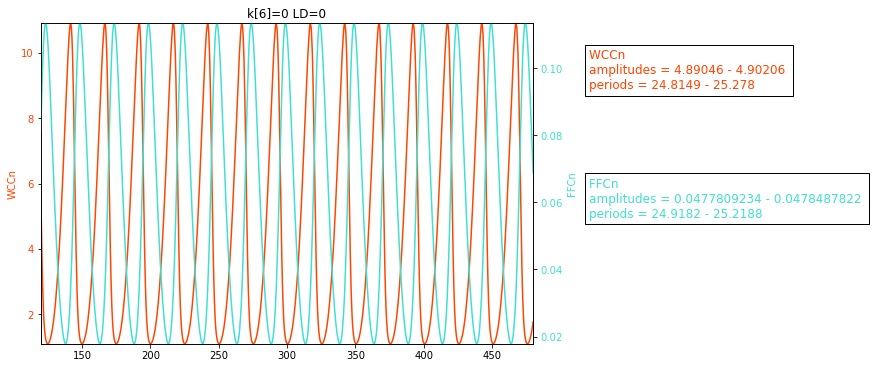

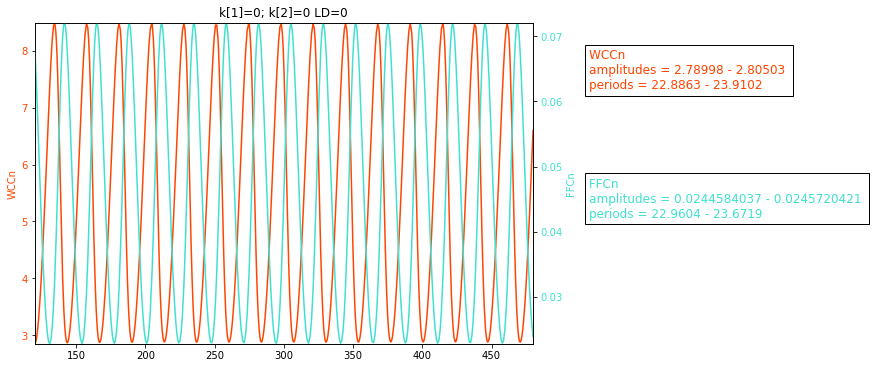

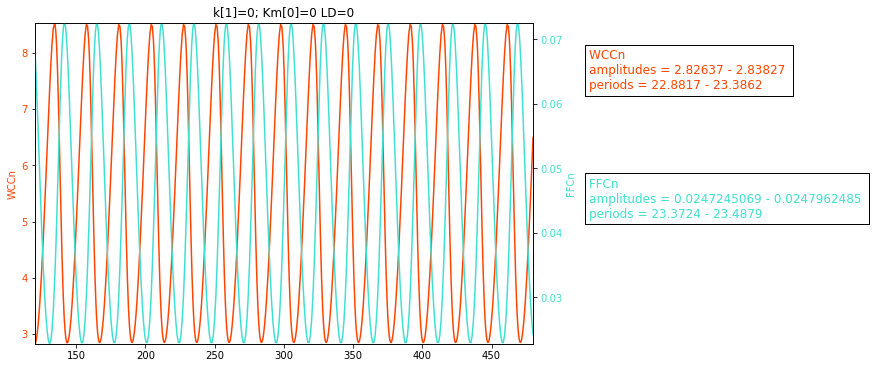

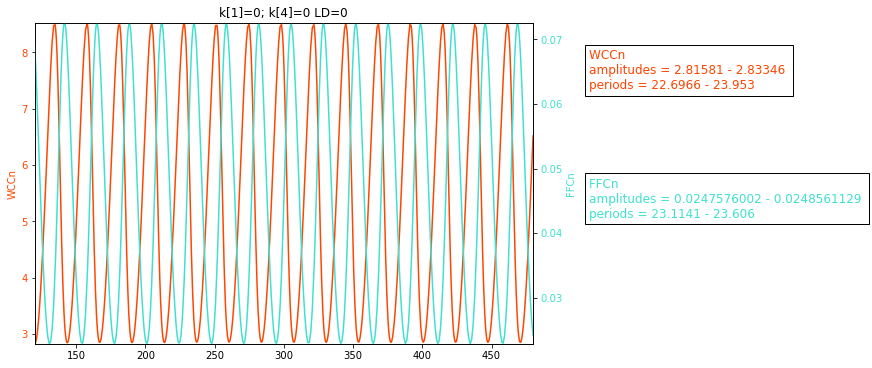

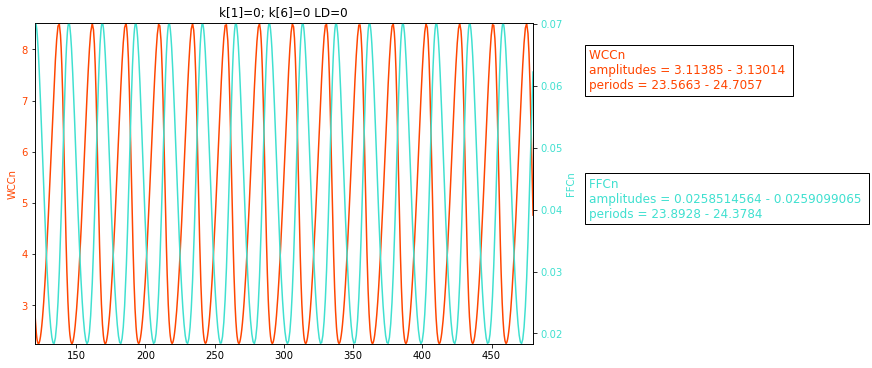

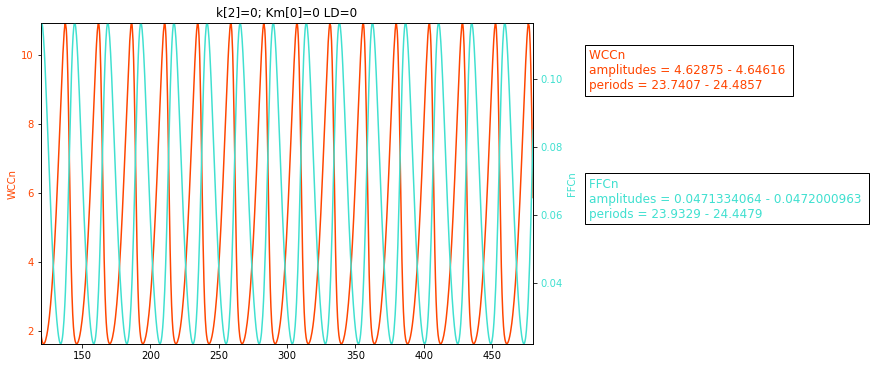

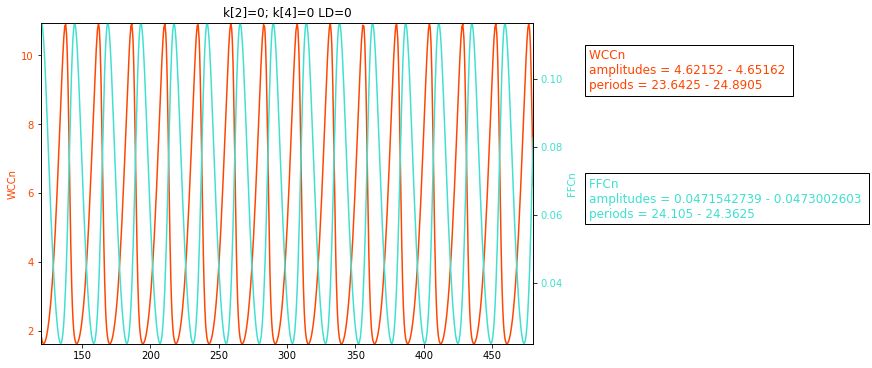

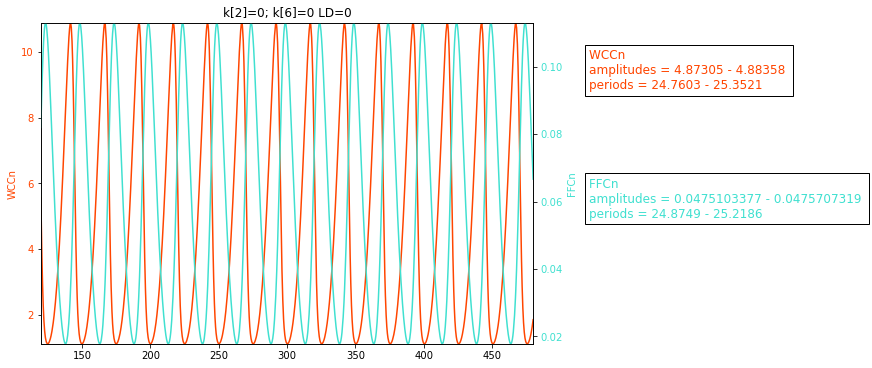

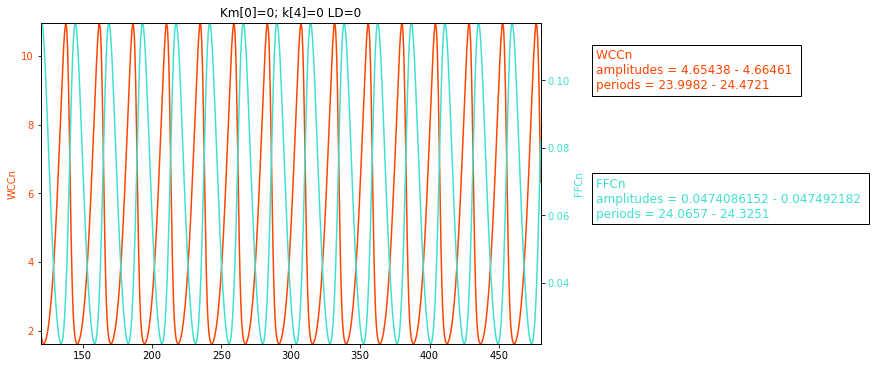

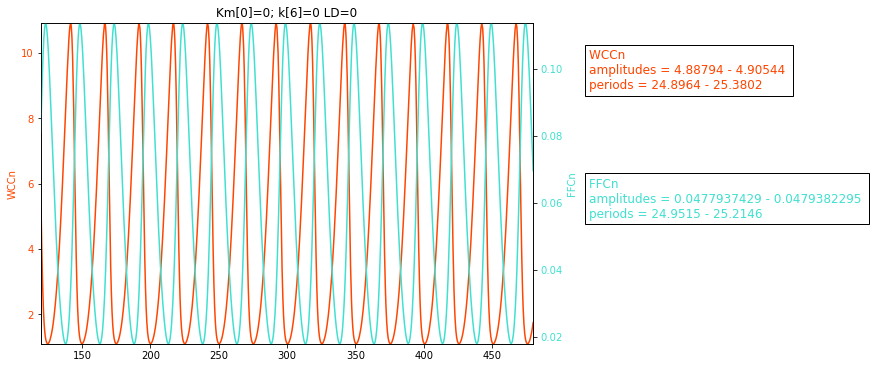

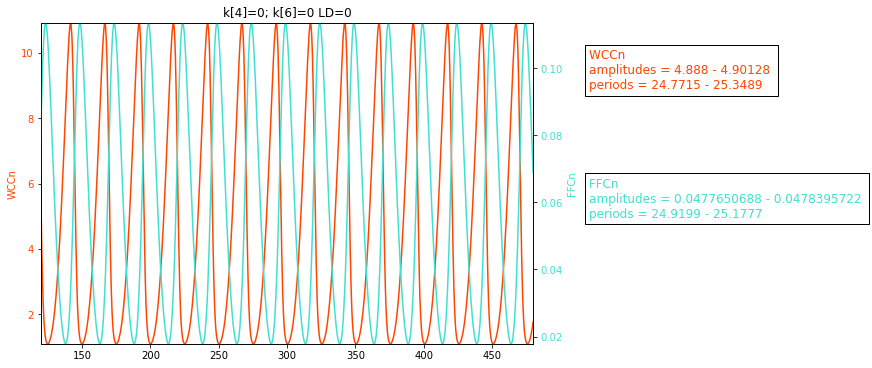

In [284]:
omega=13
x0 = np.zeros(15)
ip=1
if ip==0:
    k0 = [1.19*omega,1.2,90,1.6*omega,0.03,0.226,0.8,1,0.472/omega,
          0.3,0.001,0.6,0.001,20,7.3,320*omega,0.19, 0.15,0.1,0.1,800*omega,0.68,0.3]
    L0 = 0.2
    n0 = [4,4,4,4]
    Km0 = [0.03/omega,1*omega,0.475*omega,5*omega,0.1*omega,0.18*omega,0.02*omega]
elif ip==1:
    k0 = [1.19*omega, 1.2, 90, 1.6*omega, 0.03, 0.226, 2.4, 2, 0.472/omega, 0.3, 0.001, 50, 
          0.001, 20, 7.3, 320, 5.4, 0.15, 2, 0.05, 800*omega, 0.68, 0.3]
    n0 = [2,3,3,4]
    L0 = 0.3
    Km0 = [0.03/omega, 0.3*omega, 0.05*omega, 5*omega, 2*omega, 0.18*omega, 0.02*omega]
elif ip==2:
    k0 = [9.18236260e-01, 1.31272389e+00, 1.05612953e+02, 1.51368699e+00, 
          3.34960765e-02, 2.23445399e-01, 2.12373377e+00, 2e+00, 4.72000000e-01, 
          3.00000000e-01, 1.00000000e-03, 8.22563158e+00, 1.0e-03, 1.08551588e+01, 
          3.49620056e+00, 3.43058956e+02, 5.40000000e+00, 1.50e-01, 2e+00, 5e-02, 
          8.58342556e+02, 6.80000000e-01, 3.00000000e-01]
    L0 = 0.2
    n0 = [4, 4, 4, 4]
    Km0 = [0.0271708, 0.29283663, 0.04372374, 4.63129806, 3.89618486, 0.1634689, 0.01747003]
elif ip==3:
    k0 = [1.60361527e+00, 1.34698905e+00, 9.44635006e+01, 3.70162498e+00, 2.18129314e-02, 
          1.23083233e-01, 3.37528481e+00, 1.97998004e+00, 8.91902116e-01, 3.99460912e-01, 
          5.40020047e-04, 8.83366542e+00, 1.31907102e-03, 1.13631597e+01, 2.08602327e+00, 
          2.15434751e+02, 4.30201083e+00, 1.16989157e-01, 1.62312295e+00, 3.05100443e-02, 
          6.83151607e+02, 6.32459003e-01, 1.80697224e-01]
    L0 = 0.25
    n0 = [2.91692706, 7.21930474, 4.00416676, 3.15341046]
    Km0 = [4.22350262e-02, 2.43900739e-01, 4.50013924e-02, 8.08635690e+00, 5.77864438e+00, 
           9.28467919e-02, 7.86925307e-03] 
LD=0
#Mutations in k2,k3,Km1,k5,k7
KO = ["k[1]=0","k[2]=0","Km[0]=0","k[4]=0","k[6]=0"]
nk=len(KO)
for i in range(nk):
    for j in range(i,nk):
        KO.append(KO[i]+"; "+KO[j])
for ko in KO:
    k=k0[:]
    Km=Km0[:]
    exec(ko)
    sol = solve_ivp(ODE,[0,480],x0,
                    args=(k,L0,n0,Km,LD),method=solver[2])
    fig = plt.figure(figsize=(12,5),layout="constrained")
    gs = gridspec.GridSpec(1, 4, figure=fig)
    ax1 = fig.add_subplot(gs[:-1])
    y1=sol.y[5]
    amp1=max(y1[sol.t>192])-min(y1[sol.t>192])
    peaks1,_=find_peaks(y1[sol.t>120],width=5)
    p1=np.diff(sol.t[sol.t>120][peaks1])
    amp1=(y1[sol.t>120][peaks1]-min(y1[sol.t>192]))/2
    if not peaks1.size>1:
        p1=np.append(p1,0)
        amp1=np.append(amp1,0)
    
    color=["orangered","turquoise"]
    ax1.plot(sol.t,y1,color=color[0])
    ax1.tick_params(axis='y', labelcolor=color[0])
    ax1.set_ylabel('WCCn', color=color[0])
    ax1.set_xlim([120,480])
    ax1.set_ylim([min(y1[sol.t>120])*.999,max(y1[sol.t>120])*1.001])
    ax1.set_title("{} LD={}".format(ko,LD))
    
    ax2 = ax1.twinx()
    y2=sol.y[11]
    amp2=max(y2[sol.t>192])-min(y2[sol.t>192])
    peaks2,_=find_peaks(y2[sol.t>120], width=5)
    p2=np.diff(sol.t[sol.t>120][peaks2])
    amp2=(y2[sol.t>120][peaks2]-min(y2[sol.t>192]))/2
    if not peaks2.size>1:
        p2=np.append(p2,0)
        amp2=np.append(amp2,0)
    
    ax2.plot(sol.t,y2,color=color[1])
    ax2.tick_params(axis='y', labelcolor=color[1])
    ax2.set_ylabel('FFCn', color=color[1])
    ax2.set_ylim([min(y2[sol.t>120])*.99999,max(y2[sol.t>120])*1.00001])
    
    ax3 = fig.add_subplot(gs[-1])
    text = ("WCCn \namplitudes = {} - {} ".format(round(amp1.min(),5),round(amp1.max(),5))+
            "\nperiods = {} - {}".format(round(p1.min(),4),round(p1.max(),4)))
    ax3.text(-.1,0.8,text,c=color[0], fontsize=12, ha="left", wrap=True, bbox=dict(fc="none"))
    text = ("FFCn \namplitudes = {} - {} ".format(round(amp2.min(),10),round(amp2.max(),10))+
            "\nperiods = {} - {}".format(round(p2.min(),4),round(p2.max(),4)))
    ax3.text(-.1,0.4,text,c=color[1], fontsize=12, ha="left", wrap=True, bbox=dict(fc="none"))
    ax3.set(xlim=(-0.15, 1.15), ylim=(0, 1))
    ax3.axis("off")
    plt.savefig("Result/{}_LD={}_ip{}.jpg".format(ko,LD,ip))
    plt.show()

periods= [25.53133469 24.6007714  24.30452367 24.2472395  24.26485063 24.45276862
 24.78139398 25.42470511 25.2751041  24.43444374 23.69118835 24.18704978
 23.76873017 24.11590227 24.04794196 23.98082476 23.99208482 24.02385751
 23.89765405 24.12290215 23.86165663 24.04927667 24.10310312 23.88260955
 23.98610634 23.99498043 23.98199109 23.99908472 24.00755884 24.05078701
 23.94428691 23.99623649 24.05676157 23.95088357 24.1148623  23.88393543
 24.00471531 23.99199702 24.02879931 24.0236882  23.97731138 23.97895225
 23.98974447 23.99854073 24.11244471 23.89519934 24.0611487  23.93440331
 23.99826546 24.13156508 23.87006698 23.9991114  24.03067802 24.1089964
 23.86031916 24.13956983 23.95244038 23.94076846 23.96675986 24.06267666
 23.9400609 ] 
 period= 24.11487893876144


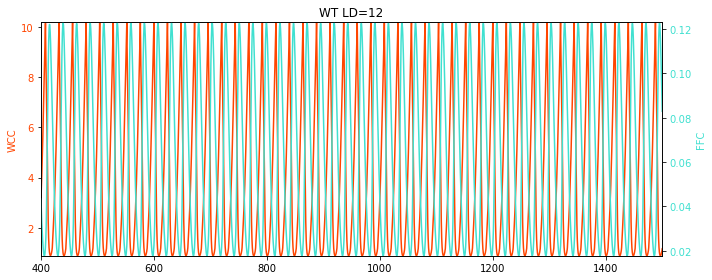

In [327]:
omega=13
x0 = np.zeros(15)
k0 = [1.19*omega, 1.2, 90, 1.6*omega, 0.03, 0.226, 2.4, 2, 0.472/omega, 0.3, 0.001, 50, 
      0.001, 20, 7.3, 320, 5.4, 0.15, 2, 0.05, 800*omega, 0.68, 0.3]
n0 = [2,3,3,4]
L0 = 0.3
Km0 = [0.03/omega, 0.3*omega, 0.05*omega, 5*omega, 2*omega, 0.18*omega, 0.02*omega]
LD=12
#Km0[0]=0
k0[6]=0
sol=solve_ivp(ODE,[0,1500],x0,args=(k0,L0,n0,Km0,LD),method=solver[2])
fig,ax1 = plt.subplots(figsize=(10,4))
y1=sol.y[5]
color="orangered"
ax1.plot(sol.t,y1,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('WCC', color=color)
ax1.set_xlim([400,1500])
ax1.set_ylim([min(y1[sol.t>400]),max(y1[sol.t>400])])
amp=max(y1[sol.t>192])-min(y1[sol.t>192])


ax2 = ax1.twinx()
y2=sol.y[11]
color="turquoise"
ax2.plot(sol.t,y2,color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('FFC', color=color)
ax2.set_ylim([min(y2[sol.t>400]),max(y2[sol.t>400])])
amp=max(y2[sol.t>192])-min(y2[sol.t>192])
plt.title("WT LD="+str(LD))
fig.tight_layout()
peaks,_=find_peaks(y2)
p=np.diff(sol.t[peaks])
print("periods=",p,"\n period=",np.mean(p))

In [328]:
sol.y[:,-1]

array([7.83615196e+00, 8.29981218e+00, 2.79396640e-01, 1.69734162e+02,
       5.03462644e+00, 1.16752201e+00, 2.55757305e-02, 4.13036922e-04,
       7.89397592e-02, 6.33599776e-03, 2.18862747e-01, 8.29026627e-02,
       1.27122407e-01, 2.01280738e+00, 5.43086126e+01])

In [111]:
omega=13
x0 = np.array([7.83615196e+00, 8.29981218e+00, 2.79396640e-01, 1.69734162e+02,
       5.03462644e+00, 1.16752201e+00, 2.55757305e-02, 4.13036922e-04,
       7.89397592e-02, 6.33599776e-03, 2.18862747e-01, 8.29026627e-02,
       1.27122407e-01, 2.01280738e+00, 5.43086126e+01])
k0 = [1.19*omega, 1.2, 90, 1.6*omega, 0.03, 0.226, 2.4, 2, 0.472/omega, 0.3, 0.001, 50, 
      0.001, 20, 7.3, 320, 5.4, 0.15, 2, 0.05, 800*omega, 0.68, 0.3]
n0 = [2,3,3,4]
L0 = 0.3
Km0 = [0.03/omega, 0.3*omega, 0.05*omega, 5*omega, 2*omega, 0.18*omega, 0.02*omega]
param=[0]*35
param[0:23]=k0
param[23:27]=n0
param[27:34]=Km0
param[34]=L0
LD=0
exp=np.exp(np.arange(-3,3,step=.1))
data_periods=np.array([[0]*len(exp)]*35)
data_amp=np.empty((35,len(exp)),dtype="object")
for j in range(35):
    d1=np.zeros(len(exp))
    d2=np.empty_like(d1,dtype="object")
    n=copy.copy(param[j])
    for i in range(len(exp)):
        param[j] = n*exp[i]
        k1 = param[0:23]
        n1 = param[23:27]
        Km1 = param[27:34]
        L1 = param[34]
        t=np.arange(0,960,.1)
        try:
            sol = solve_ivp(ODE,[0,960],x0,t_eval=t,
                                 args=(k1,L1,n1,Km1,LD),method=solver[0])
        except:
            sol = solve_ivp(ODE,[0,960],x0,t_eval=t,
                                 args=(k1,L1,n1,Km1,LD),method=solver[2])
        finally:
            if not sol.success:
                sol = solve_ivp(ODE,[0,960],x0,t_eval=t,
                                 args=(k1,L1,n1,Km1,LD),method=solver[1])
        t=sol.t[sol.t>480]
        x1=sol.y[5][sol.t>480]
        peaks1,_=find_peaks(x1)
        peaks2,_=find_peaks(x1*-1)
        periods=np.diff(t[peaks2])
        if not peaks1.size>1:
            periods=np.array([0])
        d1[i] = np.mean(periods)
        d2[i] = peak_prominences(x1,peaks1)[0].round(4)
        if not d2[i].size>0:
            d2[i]=np.array([0])
        d2[i] = pd.unique(d2[i])
        
    print(str(j)+"/35")
    param[0:23]=k0
    param[23:27]=n0
    param[27:34]=Km0
    param[34]=L0
    data_periods[j]=d1
    data_amp[j]=d2

0/35
1/35
2/35
3/35
4/35
5/35
6/35
7/35
8/35
9/35
10/35
11/35
12/35
13/35
14/35
15/35
16/35
17/35
18/35
19/35
20/35
21/35
22/35


C:\Users\emman\AppData\Local\Temp\ipykernel_8360\1444376837.py:29: RuntimeWarning: invalid value encountered in scalar power
  v11 = float(k[11]*y[5]*(pow(y[11],n[0]))/(pow(y[11],n[0]) +
C:\Users\emman\AppData\Local\Temp\ipykernel_8360\1444376837.py:32: RuntimeWarning: invalid value encountered in scalar power
  v13 = float(k[13]*y[6]*(pow(y[14],n[1]))/(pow(y[14],n[1]) +


23/35
24/35


C:\Users\emman\AppData\Local\Temp\ipykernel_8360\1444376837.py:36: RuntimeWarning: invalid value encountered in scalar power
  pow(K[4]*y[6],n[2])))
C:\Users\emman\AppData\Local\Temp\ipykernel_8360\1444376837.py:37: RuntimeWarning: invalid value encountered in scalar power
  v15 = float(k[15]*(pow(K[4]*y[6],n[2]))/(pow(K[4]*K[5],n[2]) +
C:\Users\emman\AppData\Local\Temp\ipykernel_8360\1444376837.py:39: RuntimeWarning: invalid value encountered in scalar power
  pow(K[4]*y[6],n[2])))
C:\Users\emman\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
C:\Users\emman\AppData\Local\Temp\ipykernel_8360\1444376837.py:34: RuntimeWarning: invalid value encountered in scalar power
  v14 = float(k[14]*(pow(K[5]*y[5],n[2]))/(pow(K[4]*K[5],n[2]) +
C:\Users\emman\AppData\Local\Temp\ipykernel_8360\1444376837.py:35: RuntimeWarning: invalid value encountered in scalar

25/35


C:\Users\emman\AppData\Local\Temp\ipykernel_8360\1444376837.py:44: RuntimeWarning: invalid value encountered in scalar power
  v20 = float(k[20]*float(pow(y[6],n[3]))/(float(pow(K[6],n[3])) +
C:\Users\emman\AppData\Local\Temp\ipykernel_8360\1444376837.py:45: RuntimeWarning: invalid value encountered in scalar power
  float(pow(y[6],n[3]))))


26/35
27/35
28/35
29/35
30/35
31/35
32/35
33/35
34/35


(500.0, 1000.0)

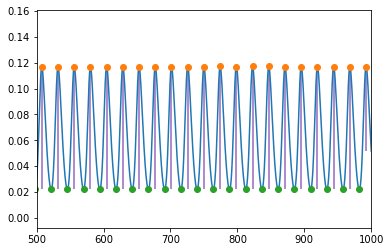

In [285]:
t=np.arange(0,1000,.1)
sol=solve_ivp(ODE,[0,1000],x0,t_eval=t,args=(k0,L0,n0,Km0,LD),method=solver[2])
y1=sol.y[11]
prom=max(y1[sol.t>240])-min(y1[sol.t>240])
peaks1,_=find_peaks(y1,prominence=prom*.05)
peaks2,_=find_peaks(y1*-1,prominence=prom*.05)
widths=peak_prominences(y1,peaks1)[0]
plt.vlines(t[peaks1],y1[peaks1]-widths,y1[peaks1],colors="C4")
plt.plot(sol.t,sol.y[11])
plt.plot(sol.t[peaks1],sol.y[11][peaks1],"o")
plt.plot(sol.t[peaks2],sol.y[11][peaks2],"o")
plt.xlim([500,1000])

In [113]:
amp=pd.DataFrame(data_amp)
for i in range(len(exp)):
    amp[i]=amp[i].apply(max)
amp=amp.set_axis(["a"+str(i) for i in range(35)],axis=0)
data=pd.DataFrame(data_periods,index=["p"+str(i) for i in range(35)])
data=pd.concat([data,amp])
data

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
p0,33.0000,33.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,32.0000,31.0000,...,19.0000,19.0000,19.0000,18.0000,18.0000,18.0000,18.0000,18.0000,18.0000,18.0000
p1,23.0000,23.0000,23.0000,23.0000,23.0000,23.0000,23.0000,23.0000,23.0000,23.0000,...,26.0000,27.0000,27.0000,27.0000,27.0000,26.0000,26.0000,26.0000,26.0000,25.0000
p2,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,...,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000
p3,21.0000,26.0000,26.0000,26.0000,26.0000,25.0000,25.0000,25.0000,24.0000,24.0000,...,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000
p4,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,...,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000,24.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a30,9.3253,9.3255,9.3210,9.3261,9.3215,9.3260,9.3261,9.3265,9.3265,9.3238,...,9.3214,9.3214,9.3214,9.3214,9.3214,9.3214,9.3214,9.3214,9.3214,9.3214
a31,0.0221,0.0302,0.0364,0.0438,0.0705,0.1636,0.3282,0.5521,0.7804,1.0065,...,19.8627,18.7713,16.8184,13.7551,10.5564,7.6525,4.7829,2.7506,2.1885,1.9718
a32,9.3224,9.3184,9.3237,9.3245,9.3241,9.3206,9.3208,9.3206,9.3254,9.3250,...,9.3212,9.3257,9.3264,9.3212,9.3278,9.3252,9.3212,9.3268,9.3264,9.3258
a33,9.3354,9.3349,9.3347,9.3333,9.3349,9.3356,9.3294,9.3320,9.3346,9.3338,...,9.3258,9.3239,9.3267,9.3258,9.3259,9.3265,9.3254,9.3253,9.3249,9.3248


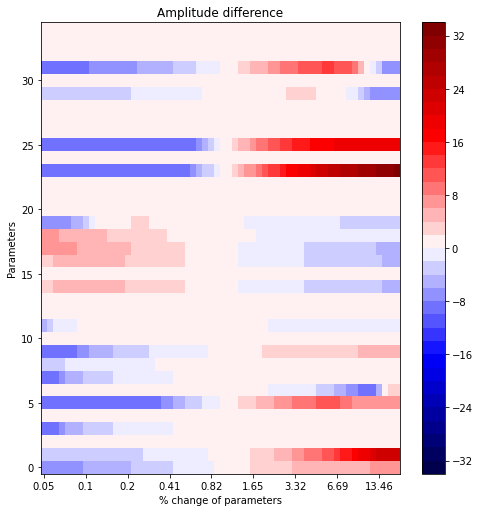

In [114]:
a=data.loc[["a"+str(i) for i in range(35)]]-8.7561
mx=np.array(a.abs()).max()
levels = MaxNLocator(nbins=35).tick_values(-mx, mx)
cmap = plt.colormaps['seismic']
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
fig, ax = plt.subplots(figsize=(7,7))
im = ax.pcolormesh([str(e) for e in exp],range(35),
                   a,cmap=cmap,norm=norm)
fig.colorbar(im, ax=ax)
tick=np.arange(len(exp),step=7)
ax.set_xticks(tick,exp.round(2)[tick])
ax.set_xlabel("% change of parameters")
ax.set_ylabel("Parameters")
fig.tight_layout()
plt.title("Amplitude difference")
plt.show()

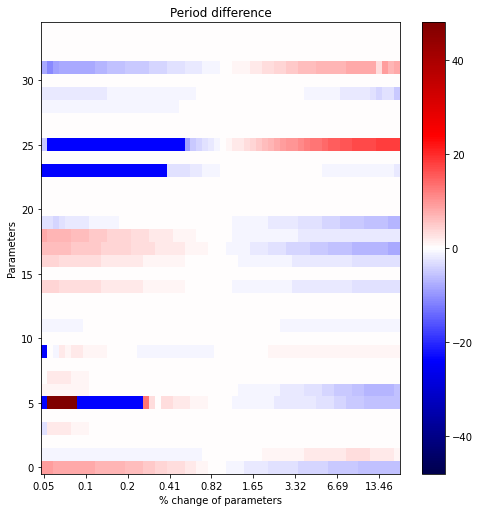

In [128]:
p=data.loc[["p"+str(i) for i in range(35)]]-24
mx=np.array(p.abs()).max()
cmap = plt.colormaps['seismic']
fig, ax = plt.subplots(figsize=(7,7))
im = ax.pcolormesh([str(e) for e in exp],range(35),
                   p,cmap=cmap,norm=Normalize(-24, 24))
fig.colorbar(im, ax=ax)
tick=np.arange(len(exp),step=7)
ax.set_xticks(tick,exp.round(2)[tick])
ax.set_xlabel("% change of parameters")
ax.set_ylabel("Parameters")
fig.tight_layout()
plt.title("Period difference")
plt.show()

In [552]:
8.756148
np.exp(np.arange(-3,3,step=.1))

array([ 0.04978707,  0.05502322,  0.06081006,  0.06720551,  0.07427358,
        0.082085  ,  0.09071795,  0.10025884,  0.11080316,  0.12245643,
        0.13533528,  0.14956862,  0.16529889,  0.18268352,  0.20189652,
        0.22313016,  0.24659696,  0.27253179,  0.30119421,  0.33287108,
        0.36787944,  0.40656966,  0.44932896,  0.4965853 ,  0.54881164,
        0.60653066,  0.67032005,  0.74081822,  0.81873075,  0.90483742,
        1.        ,  1.10517092,  1.22140276,  1.34985881,  1.4918247 ,
        1.64872127,  1.8221188 ,  2.01375271,  2.22554093,  2.45960311,
        2.71828183,  3.00416602,  3.32011692,  3.66929667,  4.05519997,
        4.48168907,  4.95303242,  5.47394739,  6.04964746,  6.68589444,
        7.3890561 ,  8.16616991,  9.0250135 ,  9.97418245, 11.02317638,
       12.18249396, 13.46373804, 14.87973172, 16.44464677, 18.17414537])

In [636]:
import collections
D=[]
for i in range(35):
    D.append((data.loc["a"+str(i)].max()-
              data.loc["a"+str(i)].min())/data.loc["a"+str(i)].max())
np.arange(35)[np.array(D)<0.1]

array([ 4, 10, 27])

In [147]:
omega=13
x0 = np.array([7.83615196e+00, 8.29981218e+00, 2.79396640e-01, 1.69734162e+02,
       5.03462644e+00, 1.16752201e+00, 2.55757305e-02, 4.13036922e-04,
       7.89397592e-02, 6.33599776e-03, 2.18862747e-01, 8.29026627e-02,
       1.27122407e-01, 2.01280738e+00, 5.43086126e+01])
k0 = [1.19*omega, 1.2, 90, 1.6*omega, 0.03, 0.226, 2.4, 2, 0.472/omega, 0.3, 0.001, 50, 
      0.001, 20, 7.3, 320, 5.4, 0.15, 2, 0.05, 800*omega, 0.68, 0.3]
n0 = [4,4,4,4]
L0 = 0.3
Km0 = [0.03/omega, 0.3*omega, 0.05*omega, 5*omega, 2*omega, 0.18*omega, 0.02*omega]
k0[6]=0
param=np.zeros(35)
param[0:23]=k0
param[23:27]=n0
param[27:34]=Km0
param[34]=L0
LD=0
t0=np.arange(0,960,.1)
exp=10**(1-2*np.random.rand(1000,35))
exp[:,23:27]=5**(1-(2*np.random.rand(1000,4)))
data_periods=np.zeros(len(exp))
data_amp=np.empty(len(exp),dtype="object")
data_param=np.empty((len(exp),35))
for i in range(len(exp)):
    param *= exp[i]
    k1 = param[0:23]
    n1 = param[23:27].round(4)
    Km1 = param[27:34]
    L1 = param[34]
    try:
        sol = solve_ivp(ODE,[0,960],x0,t_eval=t0,rtol=1e-14,atol=1e-20,
                        args=(k1,L1,n1,Km1,LD),method=solver[0])
    except:
        sol = solve_ivp(ODE,[0,960],x0,t_eval=t0,rtol=1e-14,atol=1e-20,
                        args=(k1,L1,n1,Km1,LD),method=solver[2])
    finally:
        if not sol.success:
            sol=solve_ivp(ODE,[0,960],x0,t_eval=t0,rtol=1e-14,atol=1e-20,
                          args=(k1,L1,n1,Km1,LD),method="DOP853")
    
    t=t0[t0>624]
    x1=sol.y[5][sol.t>624]
    
    f = np.fft.fft(x1)
    f = np.nan_to_num(f)
    freq = np.fft.fftfreq(len(x1),d=.1)
    freq_m = freq[abs(f)==max(abs(f[freq>0]))][0]
    
    amplitude=max(x1)-min(x1)
    peaks1,_=find_peaks(x1,prominence=amplitude*.2)
    peaks2,_=find_peaks(x1,prominence=amplitude*.8)
    periods=np.diff(t[peaks2])
    if peaks2.size<7:
        periods=np.array([0])
    if freq_m>0.5:
        periods=np.array([-1])
    data_periods[i] = np.mean(periods)
    data_amp[i] = peak_prominences(x1,peaks1)[0]
    if peaks2.size<7 or freq_m>0.5:
        data_amp[i]=np.array([0])
    
    data_amp[i] = pd.unique(data_amp[i])
    data_param[i]=param[:]
    
    param[0:23]=k0
    param[23:27]=n0
    param[27:34]=Km0
    param[34]=L0

C:\Users\emman\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
C:\Users\emman\AppData\Local\Temp\ipykernel_9548\2709832013.py:29: RuntimeWarning: invalid value encountered in scalar power
  v11 = float(k[11]*y[5]*(pow(y[11],float(n[0])))/(pow(y[11],float(n[0])) +
C:\Users\emman\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
C:\Users\emman\AppData\Local\Temp\ipykernel_9548\2709832013.py:32: RuntimeWarning: invalid value encountered in scalar power
  v13 = float(k[13]*y[6]*(pow(y[14],float(n[1])))/(pow(y[14],float(n[1])) +


In [21]:
sol.success

False

In [32]:
#plt.plot(t,x1)
#plt.xlim((sol.t[sol.y[13]<0])[0],472.2)
#plt.ylim(-1e-40,0)
#print(sol)

In [148]:
amp=pd.DataFrame(data_amp)
amp=amp.apply(max,axis=1).apply(max)
data=pd.DataFrame(data_periods)
data=pd.concat([data,amp],axis=1,ignore_index=True)
data.set_axis(["Period","Amplitude"],axis='columns')
data_param=pd.DataFrame(data_param)

In [149]:
data.to_csv("Result/data_pa_LD{}_k[6]=0_0.csv".format(LD))
data_param.to_csv("Result/data_param_LD{}_k[6]=0_0.csv".format(LD))
data

,0,1
0,24.341667,7.644205
1,28.770000,10.317976
2,0.000000,0.000000
3,42.766667,2.322566
4,24.383333,17.965280
...,...,...
995,28.900000,2.233756
996,0.000000,0.000000
997,0.000000,0.000000
998,0.000000,0.000000


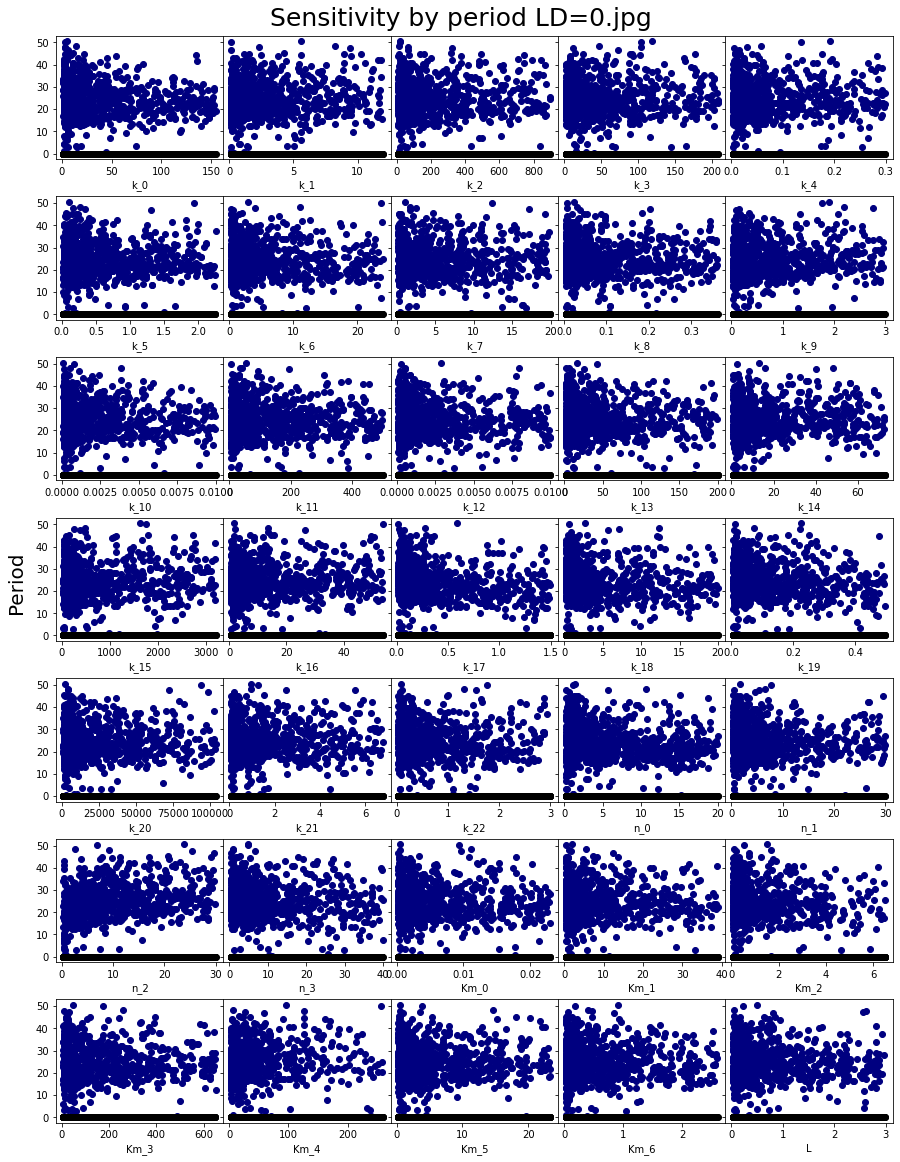

In [25]:
fig,ax=plt.subplots(7,5,sharey=True,figsize=(15,20))
for i in range(35):
    if i<23:
        s = "k_"
        j=i
    elif i<27:
        s = "n_"
        j=i-23
    elif i<34:
        s = "Km_"
        j=i-27
    else:
        s = "L"
        j=""
    ax[i//5,i%5].scatter(data_param[i][data[0]>0],
                         data[0][data[0]>0],color="navy")
    ax[i//5,i%5].scatter(data_param[i][data[0]<0],
                         data[0][data[0]<0],color="lime")
    ax[i//5,i%5].scatter(data_param[i][data[0]==0],
                         data[0][data[0]==0],color="black")
    ax[i//5,i%5].set_xlabel(s+str(j))
plt.subplots_adjust(wspace=0,hspace=.3)
fig.supylabel("Period",position=(0.08,.5),fontsize=20)
plt.suptitle("Sensitivity by period LD={}.jpg".format(LD),position=(0.5,0.9),fontsize=25)
plt.savefig("Result/Sensitivity_period_LD={}.jpg".format(LD))
plt.show()

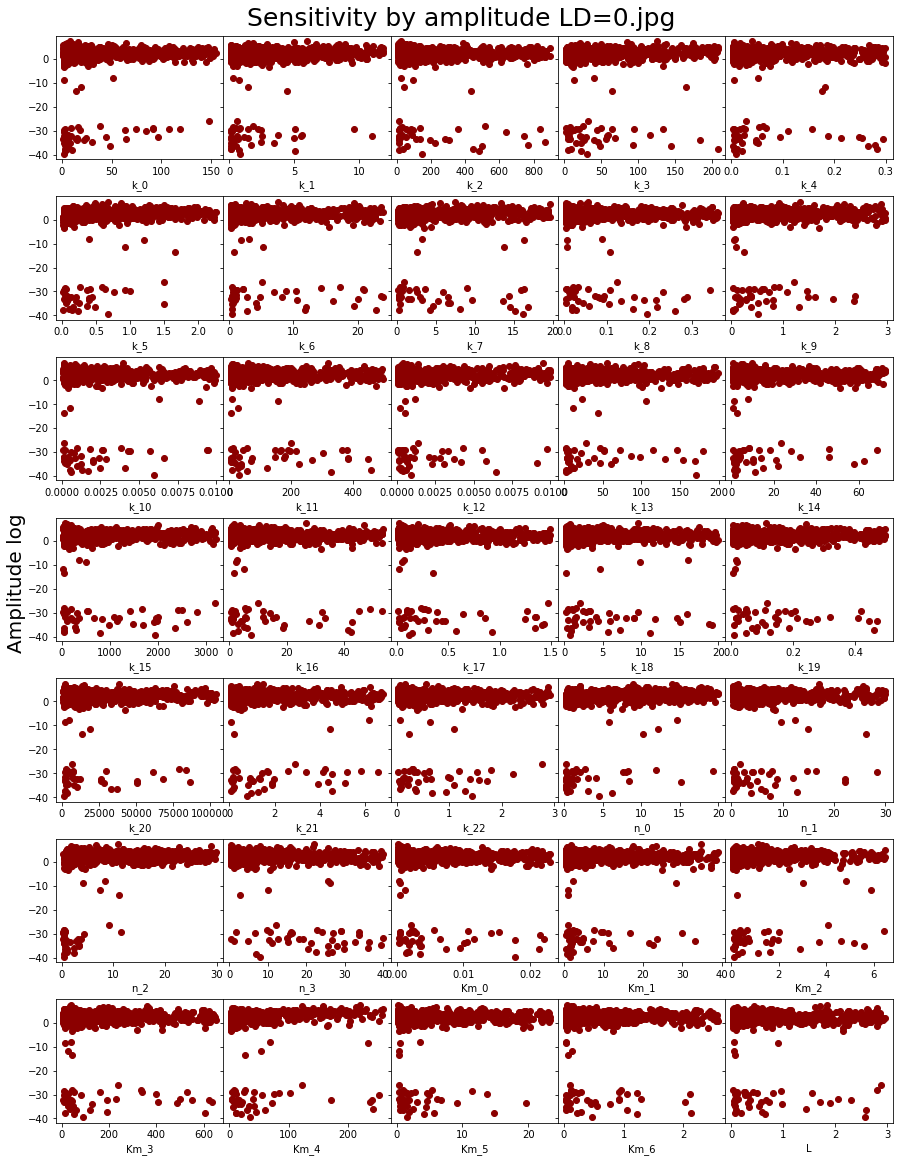

In [26]:
fig,ax=plt.subplots(7,5,sharey=True,figsize=(15,20))
for i in range(35):
    if i<23:
        s = "k_"
        j=i
    elif i<27:
        s = "n_"
        j=i-23
    elif i<34:
        s = "Km_"
        j=i-27
    else:
        s = "L"
        j=""
    ax[i//5,i%5].scatter(data_param[i][data[0]>0],
                         np.log(data[1][data[0]>0]),color="darkred")
    """ax[i//5,i%5].scatter(data_param[i][data[0]<0],
                         np.log(data[1][data[0]<0]),color="lime")
    ax[i//5,i%5].scatter(data_param[i][data[0]==0],
                         np.log(data[1][data[0]==0]),color="black")"""
    ax[i//5,i%5].set_xlabel(s+str(j))
    #ax[i//5,i%5].set_ylim([0,1000])
plt.subplots_adjust(wspace=0,hspace=.3)
fig.supylabel("Amplitude log",position=(0.08,.5),fontsize=20)
plt.suptitle("Sensitivity by amplitude LD={}.jpg".format(LD),position=(0.5,0.9),fontsize=25)
plt.savefig("Result/Sensitivity_amplitude_LD={}.jpg".format(LD))
plt.show()

In [116]:
def floating(a1):
    return a1.apply(float)

param[0:23]=k0
param[23:27]=n0
param[27:34]=Km0
param[34]=L0
param_n=data_param/param
param_n=np.log(param_n.apply(floating))+np.log(10)
p_n=24
h_n=int(10*np.log(10))
Zo=np.zeros((int(h_n*7)+1,5*p_n))
Zno=np.zeros((h_n+1,35*2))
for i in range(len(data[0])):
    i1=list(param_n.loc[i]*(h_n/4.6))
    i2=int(data[0][i]*(p_n/48)) -1
    if i2>p_n-1:
        i2=p_n-1
    for j in range(35):
        if data[0][i]>0:
            Zo[int(i1[j])+(j%7)*h_n,i2+(j//7)*p_n]+=1
        else:
            Zno[int(i1[j]),i2+j*2]+=1

5.0

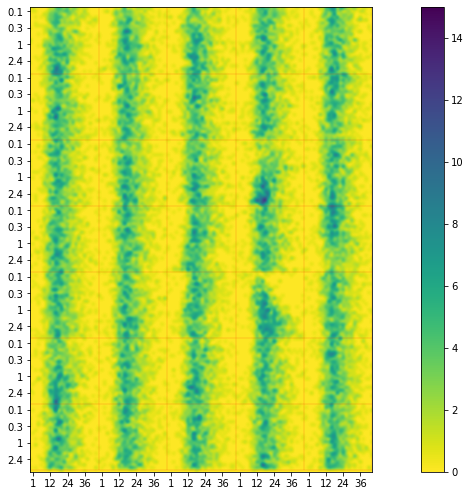

In [142]:
#p=data.loc[["p"+str(i) for i in range(35)]]-24
cmap = plt.colormaps['viridis_r']
fig, ax = plt.subplots(figsize=(14,7))
im = ax.imshow(Zo,cmap=cmap,norm=Normalize(),interpolation="bicubic")
fig.colorbar(im, ax=ax)
ax.hlines(np.arange(h_n,len(Zo),(len(Zo)-1)/7),xmin=0,xmax=len(Zo[0])-1,colors="r",alpha=0.1)
ax.vlines(np.arange(p_n,len(Zo[0]),(len(Zo[0])-1)/5),ymin=0,ymax=len(Zo)-1,colors="r",alpha=0.1)
tick=["1","12","24","36"]*5
n=np.array(list(np.arange(p_n,step=p_n/4))*5)
m=np.arange(len(Zo[0])-1,step=p_n)
nm=n.reshape(5,4)+(m.reshape(len(m),1)+1)
ax.set_xticks(nm.reshape(20),labels=tick)
n=np.array(list(np.arange(h_n,step=h_n/4))*7)
m=np.arange(len(Zo),step=len(Zo)/7)
nm=n.reshape(7,4)+(m.reshape(len(m),1)+1)
tick=["0.1","0.3","1","2.4"]*7
ax.set_yticks(nm.reshape(28),tick)
ax.set_xlim(0,len(Zo[0])-1)
fig.tight_layout()
plt.show()

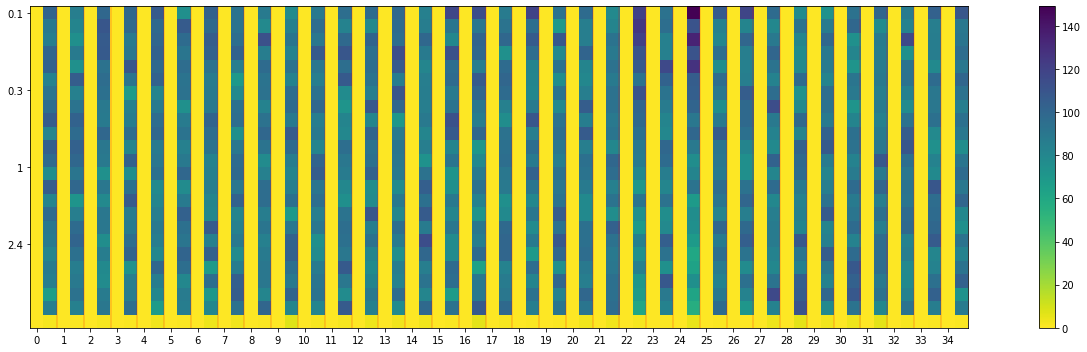

In [125]:
cmap = plt.colormaps['viridis_r']
fig, ax = plt.subplots(figsize=(20,5))
im = ax.imshow(Zno,cmap=cmap,norm=Normalize(),interpolation="nearest")
fig.colorbar(im, ax=ax)
ax.vlines(np.arange(1.5,len(Zno[0])-.5,2),ymin=-0.5,ymax=len(Zno)-0.5,colors="r",alpha=0.2)
n=np.array(np.arange(70,step=2))
ax.set_xticks(n,labels=n//2)
n=np.arange(h_n,step=h_n/4)
tick=["0.1","0.3","1","2.4"]
ax.set_yticks(n,tick)
ax.set_xlim(-0.5,len(Zno[0])-.5)
fig.tight_layout()
plt.show()

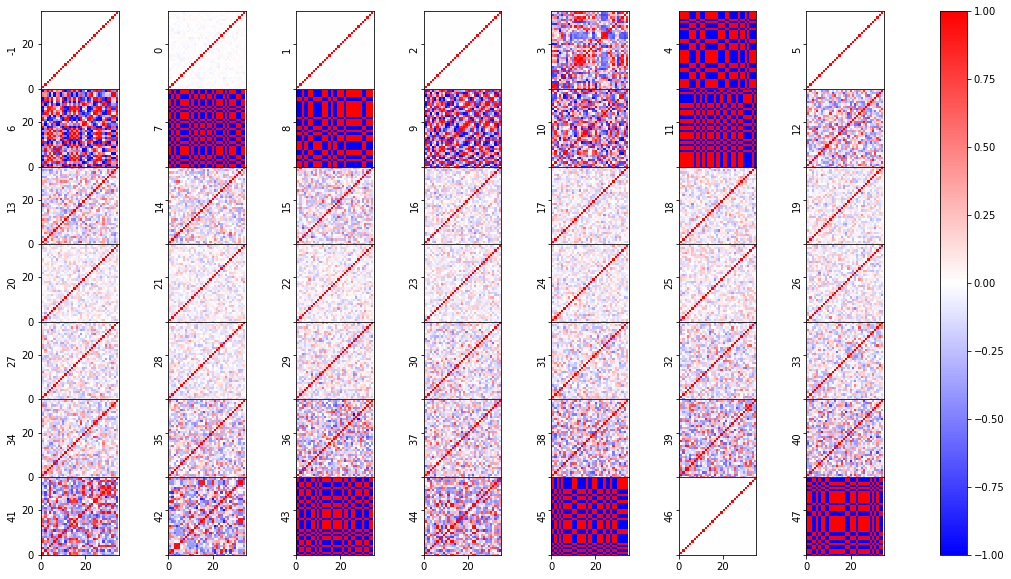

In [31]:
cmap = plt.colormaps['bwr']
fig, ax = plt.subplots(7,7,figsize=(20,10),sharex=True,sharey=True)
for i in range(-1,48):
    ax[(i+1)//7,(i+1)%7].set_ylabel(i)
    if len(data_param.loc[list(data[0].apply(int)==i)])<2:
        ax[(i+1)//7,(i+1)%7].imshow(np.identity(35),cmap=cmap,norm=Normalize(vmin=-1,vmax=1),interpolation="nearest")
        ax[(i+1)//7,(i+1)%7].set_xlim(0,35)
        ax[(i+1)//7,(i+1)%7].set_ylim(0,35)
        continue
    Zcorr = np.corrcoef(np.array(data_param.loc[list(data[0].apply(int)==i)],dtype=float),
                   rowvar=False)
    im = ax[(i+1)//7,(i+1)%7].imshow(Zcorr,cmap=cmap,norm=Normalize(vmin=-1,vmax=1),interpolation="nearest")
plt.subplots_adjust(wspace=0,hspace=0)
fig.colorbar(im, ax=ax)
plt.show()

In [384]:
np.mean(np.diff(t[peaks]))

4.233928571428572

In [285]:
T=data[0]>=-1
F=data[0]<0
len(data[0][list(T==F)])

514

In [67]:
data[0][data[0]>48]

155     50.016667
591     50.516667
1418    48.266667
Name: 0, dtype: float64

(624.0, 960.0)

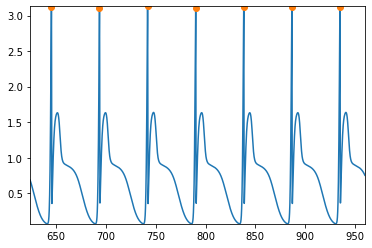

In [68]:
i=1418
param=np.array(data_param[i:i+1])[0]
k1 = param[0:23]
n1 = param[23:27]
Km1 = param[27:34]
L1 = param[34]
t=np.arange(0,960,.1)
try:
    sol = solve_ivp(ODE,[0,960],x0,t_eval=t0,
                        args=(k1,L1,n1,Km1,LD),method=solver[0])
except:
    sol=solve_ivp(ODE,[0,960],x0,t_eval=t0,rtol=1e-14,atol=1e-20,
                      args=(k1,L1,n1,Km1,LD),method="DOP853")
amplitude=max(sol.y[5][sol.t>480])-min(sol.y[5][sol.t>480])
peaks,_=find_peaks(sol.y[5],prominence=amplitude*.8)
plt.plot(sol.t,sol.y[5])
plt.plot(sol.t[peaks],sol.y[5][peaks],"o")
plt.ylim([min(sol.y[5][sol.t>400]),max(sol.y[5][sol.t>400])])
plt.xlim([624,960])

(0.0, 5.0)

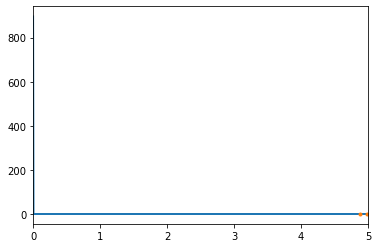

In [64]:
y=sol.y[5][sol.t>800]
f=np.fft.fft(y)
freq = np.fft.fftfreq(len(y),d=.1)
peaks,_=find_peaks(abs(f))
plt.plot(freq,abs(f),"-")
plt.plot(freq[peaks],(abs(f))[peaks],".")
plt.xlim([0,5])
#plt.ylim(0,.0005)

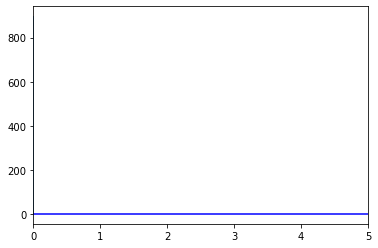

C:\Users\emman\anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
C:\Users\emman\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\emman\anaconda3\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


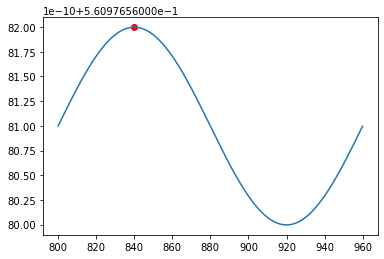

In [65]:
f=np.fft.fft(y)
freq = np.fft.fftfreq(len(y),d=.1)
f[np.abs(f)<max(abs(f[freq>0]))] = 0
f[freq==0] = max(np.fft.fft(y))
peaks,_=find_peaks(abs(f))
plt.plot(freq[peaks],abs(f[peaks]),"r.")
plt.stem(freq, np.abs(f), markerfmt=" ", basefmt="-b")
plt.xlim(0,5)
#plt.ylim(0,50)
plt.show()
peaks,_=find_peaks(np.fft.ifft(f))
plt.plot(sol.t[sol.t>800],np.fft.ifft(f))
plt.scatter(sol.t[sol.t>800][peaks],np.fft.ifft(f)[peaks],c="r")
plt.show()

In [141]:
1/freq[abs(f)==max(abs(f[freq>0]))][0]

0.7012526096033405

In [117]:
data_param.loc[13]

0       13.238994
1        2.654956
2      184.038018
3      109.050658
4         0.02322
5        0.071456
6        5.978288
7        1.499816
8        0.007813
9        0.736908
10       0.000936
11      43.323149
12       0.000301
13      10.371996
14      46.273821
15       147.7805
16      49.862633
17       0.104083
18       0.362179
19       0.029722
20    1663.627795
21       1.274062
22       0.051463
23       0.369225
24       0.424891
25       1.927076
26       3.807777
27       0.000323
28      12.738013
29       1.282496
30      145.79109
31     225.203095
32       0.327154
33        0.08852
34        0.03106
Name: 13, dtype: object